In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('historical_beach_data.csv')
data.head()

,Date & Time,Sea Surface Temp (°C),Air Temp (°C),Wind Speed (km/h),Wave Height (m),UV Index,Activity Level
0,2023-10-01 00:00:00,27.0,22.0,4.2,0.49,0.0,Low
1,2023-10-01 01:00:00,27.1,25.1,4.9,0.24,0.0,Low
2,2023-10-01 02:00:00,27.2,28.0,5.9,0.49,0.0,Low
3,2023-10-01 03:00:00,27.4,30.5,6.1,0.43,0.0,Low
4,2023-10-01 04:00:00,27.4,32.4,3.7,0.33,0.0,Low


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date & Time            384 non-null    object 
 1   Sea Surface Temp (°C)  384 non-null    float64
 2   Air Temp (°C)          384 non-null    float64
 3   Wind Speed (km/h)      384 non-null    float64
 4   Wave Height (m)        384 non-null    float64
 5   UV Index               384 non-null    float64
 6   Activity Level         384 non-null    object 
dtypes: float64(5), object(2)
memory usage: 21.1+ KB


In [4]:
data.describe()

,Sea Surface Temp (°C),Air Temp (°C),Wind Speed (km/h),Wave Height (m),UV Index
count,384.000000,384.000000,384.000000,384.000000,384.000000
mean,27.000000,22.000000,5.025521,0.296432,3.213802
std,0.352833,8.502053,1.867092,0.094764,3.960278
min,26.500000,10.000000,0.000000,0.030000,0.000000
25%,26.600000,13.500000,3.900000,0.240000,0.000000
50%,27.000000,22.000000,4.900000,0.290000,0.000000
75%,27.400000,30.500000,6.200000,0.362500,6.825000
max,27.500000,34.000000,11.500000,0.560000,13.400000


In [5]:
data['Activity Level'].unique()

array(['Low', 'Medium', 'High'], dtype=object)

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Activity Level'] = le.fit_transform(data['Activity Level'])


In [7]:
data['Activity Level'].unique()

array([1, 2, 0])

In [8]:
data.head()

,Date & Time,Sea Surface Temp (°C),Air Temp (°C),Wind Speed (km/h),Wave Height (m),UV Index,Activity Level
0,2023-10-01 00:00:00,27.0,22.0,4.2,0.49,0.0,1
1,2023-10-01 01:00:00,27.1,25.1,4.9,0.24,0.0,1
2,2023-10-01 02:00:00,27.2,28.0,5.9,0.49,0.0,1
3,2023-10-01 03:00:00,27.4,30.5,6.1,0.43,0.0,1
4,2023-10-01 04:00:00,27.4,32.4,3.7,0.33,0.0,1


In [9]:
label_mapping  = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping

{'High': 0, 'Low': 1, 'Medium': 2}

In [10]:
data['Date & Time'] = pd.to_datetime(data['Date & Time'])

data['Hour'] = data['Date & Time'].dt.hour
data['dayOfweek'] = data['Date & Time'].dt.dayofweek

In [11]:
features = ['Sea Surface Temp (°C)', 'Air Temp (°C)', 'Wind Speed (km/h)', 'Wave Height (m)', 'UV Index', 'Hour', 'dayOfweek']
X = data[features]
y = data['Activity Level']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

## Creating pytorch datasets and dataloaders

In [14]:
class BeachActivityDataset(Dataset):
  def __init__(self, features, labels):
    self.X = torch.tensor(features, dtype = torch.float32)
    self.y = torch.tensor(labels.values, dtype = torch.float32)

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  

In [15]:
train_dataset  = BeachActivityDataset(X_train_scaled, y_train)
test_dataset = BeachActivityDataset(X_test_scaled, y_test)

In [16]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
import torch.nn.functional as F

In [18]:
class ActivityLevelClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActivityLevelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.5)  

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)  
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [19]:
input_dim = X_train_scaled.shape[1]
hiddin_dim = 64
output_dim = len(y.unique())

model = ActivityLevelClassifier(input_dim, hiddin_dim, output_dim)

### loss function

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
num_epochs = 50

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0
  for X_batch, y_batch in train_loader:
    optimizer.zero_grad()
    y_pred = model(X_batch)
    loss = criterion(y_pred, y_batch.long())
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  avg_loss = epoch_loss / len(train_loader)

  if (epoch + 1) % 5 == 0 or epoch == 0:
     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/50], Loss: 1.0619
Epoch [5/50], Loss: 0.7369
Epoch [10/50], Loss: 0.5852
Epoch [15/50], Loss: 0.5670
Epoch [20/50], Loss: 0.5174
Epoch [25/50], Loss: 0.4813
Epoch [30/50], Loss: 0.4488
Epoch [35/50], Loss: 0.4183
Epoch [40/50], Loss: 0.4412
Epoch [45/50], Loss: 0.4158
Epoch [50/50], Loss: 0.3906


In [23]:
model.eval()

ActivityLevelClassifier(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Print classification report
target_names = ['High', 'Low', 'Medium']  # Adjust based on your label encoding
print(classification_report(all_labels, all_preds, target_names=target_names))


Test Accuracy: 92.21%
              precision    recall  f1-score   support

        High       0.88      0.95      0.91        22
         Low       0.97      0.95      0.96        37
      Medium       0.88      0.83      0.86        18

    accuracy                           0.92        77
   macro avg       0.91      0.91      0.91        77
weighted avg       0.92      0.92      0.92        77



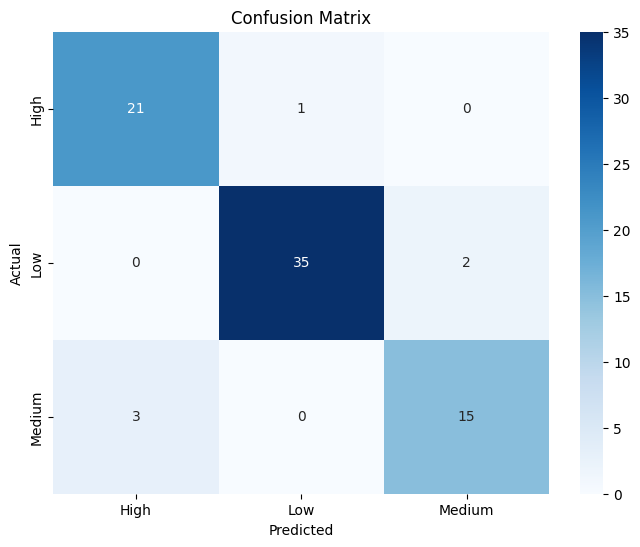

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [26]:
new_sample = {
    'Sea Surface Temp (°C)': 28.0,
    'Air Temp (°C)': 30.0,
    'Wind Speed (km/h)': 8.0,
    'Wave Height (m)': 0.5,
    'UV Index': 7.0,
    'Hour': 14,
    'dayOfweek': 5  # Corrected key to match the DataFrame
}

# Convert to DataFrame
new_sample_df = pd.DataFrame([new_sample])

# Verify the columns
print("Columns in new_sample_df:", new_sample_df.columns.tolist())

# Select and scale features
new_sample_features = new_sample_df[features]
new_sample_scaled = scaler.transform(new_sample_features)

# Convert to tensor
new_sample_tensor = torch.tensor(new_sample_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    output = model(new_sample_tensor)
    _, predicted_class = torch.max(output, 1)
    predicted_label = le.inverse_transform(predicted_class.numpy())
    print(f'Predicted Activity Level: {predicted_label[0]}')

Columns in new_sample_df: ['Sea Surface Temp (°C)', 'Air Temp (°C)', 'Wind Speed (km/h)', 'Wave Height (m)', 'UV Index', 'Hour', 'dayOfweek']
Predicted Activity Level: Low


In [27]:
torch.save(model, "complete_beach_activity_model.pth")

### Testing the model

In [28]:
model2 = torch.load("complete_beach_activity_model.pth")

In [29]:
model2.eval()

ActivityLevelClassifier(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [33]:
new_sample = {
    'Sea Surface Temp (°C)': 23.0,
    'Air Temp (°C)': 25.0,
    'Wind Speed (km/h)': 5.0,
    'Wave Height (m)': 1.0,
    'UV Index': 10.0,
    'Hour': 19,
    'dayOfweek': 3  # Corrected key to match the DataFrame
}

# Convert to DataFrame
new_sample_df = pd.DataFrame([new_sample])

# Verify the columns
print("Columns in new_sample_df:", new_sample_df.columns.tolist())

# Select and scale features
new_sample_features = new_sample_df[features]
new_sample_scaled = scaler.transform(new_sample_features)

# Convert to tensor
new_sample_tensor = torch.tensor(new_sample_scaled, dtype=torch.float32)

with torch.no_grad():
    output = model2(new_sample_tensor)
    _, predicted_class = torch.max(output, 1)
    predicted_label = le.inverse_transform(predicted_class.numpy())
    print(f'Predicted Activity Level: {predicted_label[0]}')

Columns in new_sample_df: ['Sea Surface Temp (°C)', 'Air Temp (°C)', 'Wind Speed (km/h)', 'Wave Height (m)', 'UV Index', 'Hour', 'dayOfweek']
Predicted Activity Level: Medium


In [34]:
new_sample = {
    'Sea Surface Temp (°C)': 28.0,
    'Air Temp (°C)': 30.0,
    'Wind Speed (km/h)': 8.0,
    'Wave Height (m)': 0.5,
    'UV Index': 7.0,
    'Hour': 14,
    'dayOfweek': 5  # Corrected key to match the DataFrame
}

# Convert to DataFrame
new_sample_df = pd.DataFrame([new_sample])

# Verify the columns
print("Columns in new_sample_df:", new_sample_df.columns.tolist())

# Select and scale features
new_sample_features = new_sample_df[features]
new_sample_scaled = scaler.transform(new_sample_features)

# Convert to tensor
new_sample_tensor = torch.tensor(new_sample_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    output = model(new_sample_tensor)
    _, predicted_class = torch.max(output, 1)
    predicted_label = le.inverse_transform(predicted_class.numpy())
    print(f'Predicted Activity Level: {predicted_label[0]}')

Columns in new_sample_df: ['Sea Surface Temp (°C)', 'Air Temp (°C)', 'Wind Speed (km/h)', 'Wave Height (m)', 'UV Index', 'Hour', 'dayOfweek']
Predicted Activity Level: Low
